In [36]:
!pip install matplotlib
!pip install mygene
!pip install seaborn
!pip install scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/11.0 MB 20.5 MB/s eta 0:00:01
   - -------------------------------------- 0.4/11.0 MB 4.1 MB/s eta 0:00:03
   - -------------------------------------- 0.4/11.0 MB 3.3 MB/s eta 0:00:04
   - -------------------------------------- 0.5/11.0 MB 2.9 MB/s eta 0:00:04
   -- ------------------------------------- 0.6/11.0 MB 2.5 MB/s eta 0:00:05
   -- ------------------------------------- 0.6/11.0 MB 2.2 MB/s eta 0:00:05
   -- ------------------------------------- 0.7/11.0 MB 2.0 MB/s eta 0:00:06
   -- ------------------------------------- 0.7/11.0 MB 2.0 MB/s eta 0:00:06
   -- ------------------------------------- 0.8/11.0 MB 1.9 MB/s eta 0:00:06
   --- ------------------------------------ 0.8/11.0 MB 1.9 MB/s eta 0:00:06
   --- 


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import pandas as pd
import numpy as np
import mygene as mygene
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
#Load the TSV file into a DataFrame
df = pd.read_csv("SRP158491/SRP158491.tsv", sep='\t')

nan_genes_before = df['Gene'].isna().sum()
total_genes_before = len(df['Gene'])

mg = mygene.MyGeneInfo()
query_result = mg.querymany(df['Gene'].tolist(), scopes='ensembl.gene',
                           fields='symbol', species='human')
ensembl_to_hugo = {item['query']: item.get('symbol', '') for item in query_result}
df['Gene'] = df['Gene'].map(ensembl_to_hugo)

df = df.drop_duplicates(subset='Gene', keep='first')
df.to_csv('SRP158491_converted.tsv', sep='\t', index=False)

6 input query terms found dup hits:	[('ENSG00000188660', 2), ('ENSG00000249738', 2), ('ENSG00000268674', 3), ('ENSG00000273730', 10), ('
447 input query terms found no hit:	['ENSG00000112096', 'ENSG00000116883', 'ENSG00000130489', 'ENSG00000130723', 'ENSG00000137808', 'ENS


In [43]:
df = pd.read_csv("SRP158491_converted.tsv", sep='\t')

#expression matrix
matrixSize = df.shape

#num genes
numGenes = df['Gene'].nunique()

#calculate per gene median expression ranges
medExprRate = df.iloc[:, 1:].median(axis = 1)

print(f"Expression matrix size: {matrixSize}")
print(f"Number of genes: {numGenes}")

Expression matrix size: (31645, 277)
Number of genes: 31644


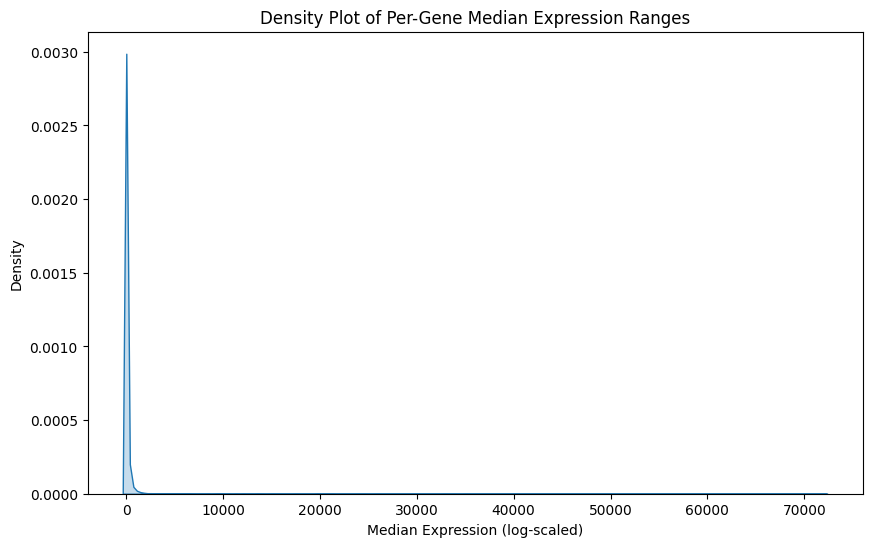

In [24]:
# Create a density plot of the median expression ranges
plt.figure(figsize=(10, 6))
sns.kdeplot(medExprRate, fill=True)
plt.title("Density Plot of Per-Gene Median Expression Ranges")
plt.xlabel("Median Expression (log-scaled)")
plt.ylabel("Density")
plt.savefig("median_expression_density_plot.png")
plt.show()

In [44]:
summary = f"""
Expression matrix size: {matrixSize}
Number of genes: {numGenes}
Median expression ranges: {medExprRate.max() - medExprRate.min()}
Mean: {medExprRate.mean()}
Standard Deviation: {medExprRate.std()}
"""

print(summary)

# Save the summary to a text file
with open("summary.txt", "w") as file:
    file.write(summary)


Expression matrix size: (31645, 277)
Number of genes: 31644
Median expression ranges: 72030.43
Mean: 120.59594630568355
Standard Deviation: 902.3163915897912



In [32]:
##################
##################
##################
##################

##### PART 2 #####

##################
##################
##################
##################

In [48]:

#csplit dataset into health vs unhealthy
patient_df = pd.read_csv("SRP158491/metadata_SRP158491.tsv", sep='\t')

healthy_rows = patient_df[patient_df['refinebio_disease'] == 'healthy']
unhealthy_rows = patient_df[patient_df['refinebio_disease'] == 'ra non treatment']

healthy_columns = healthy_rows['refinebio_accession_code'].tolist()
unhealthy_columns = unhealthy_rows['refinebio_accession_code'].tolist()

healthy_gene_expression = df[healthy_columns]
unhealthy_gene_expression = df[unhealthy_columns]

healthy_gene_expression.head
unhealthy_gene_expression.head

<bound method NDFrame.head of        SRR7725958  SRR7725959  SRR7725961  SRR7725962  SRR7725963  SRR7725964  \
0        7.492075     0.00000    0.000000    1.248145   12.207398   10.927926   
1        0.000000     0.00000    0.000000    0.000000    0.000000    0.000000   
2      101.144440   314.51630   97.422720  101.243160   65.631910  414.943360   
3       42.650870    64.08394   38.313460   46.660694   33.896935  132.990980   
4       31.444590    53.78388   53.056873   30.531454   12.615053   17.093752   
...           ...         ...         ...         ...         ...         ...   
31640    0.000000     0.00000    0.000000    0.000000    0.000000    0.000000   
31641    0.000000     0.00000    0.000000    0.000000    0.000000    0.000000   
31642    0.000000     0.00000    0.000000    0.000000    0.000000    0.000000   
31643    0.000000     0.00000    0.000000    0.000000    0.000000    0.933989   
31644    0.000000     0.00000    0.000000    0.000000    0.000000    0.000000  

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df.iloc[:, 1:].transpose())

healthy_pca = pca.transform(healthy_gene_expression.iloc[:, 1:].transpose())
unhealthy_pca = pca.transform(unhealthy_gene_expression.iloc[:, 1:].transpose())

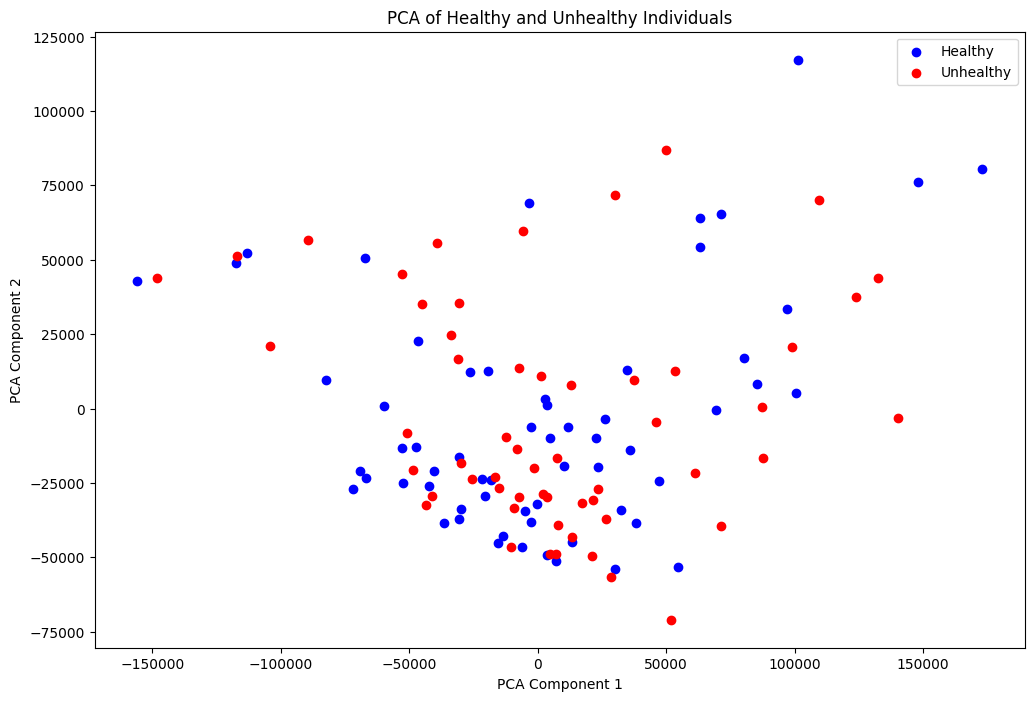

In [38]:
plt.figure(figsize=(12, 8))
plt.scatter(healthy_pca[:, 0], healthy_pca[:, 1], c='blue', label='Healthy')
plt.scatter(unhealthy_pca[:, 0], unhealthy_pca[:, 1], c='red', label='Unhealthy')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Healthy and Unhealthy Individuals')
plt.legend()
plt.show()

In [40]:
# Assuming pca has been fitted to your data
principal_components = pca.components_

# Get the feature names (if you're using pandas)
feature_names = df.columns  # Replace 'df' with your dataframe name

# Create a DataFrame to show how much each feature contributes to each component
loadings_df = pd.DataFrame(principal_components.T, columns=['PC1', 'PC2', 'PC3', ...], index=feature_names)

# Display the loadings
print(loadings_df)


ValueError: Shape of passed values is (31645, 2), indices imply (277, 4)